In [43]:
# Enhanced analysis of ESG as a risk factor
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Read the data
df = pd.read_csv('merged_data.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (176, 31)


,Ticker,YTD_Change,YTD_Return,1M_Change,1M_Return,3M_Change,3M_Return,6M_Change,6M_Return,12M_Change,...,environmentScore,socialScore,governanceScore,totalEsg,highestControversy,percentile,ratingYear,ratingMonth,beta,overallRisk
0,CSCO,-23.060479,0.769395,8.495200,1.084952,10.167764,1.101678,10.947493,1.109475,-17.983120,...,0.45,6.90,6.51,13.87,2.0,8.46,2023.0,9.0,0.819,1
1,ISRG,-24.494442,0.755056,2.542637,1.025426,28.580896,1.285809,38.591751,1.385918,-21.202454,...,3.65,9.58,7.84,21.07,1.0,32.14,2023.0,9.0,1.395,3
2,GILD,21.052629,1.210526,7.382059,1.073821,34.961602,1.349616,50.470974,1.504710,25.067617,...,1.00,14.34,7.62,22.97,2.0,39.94,2023.0,9.0,0.196,2
3,V,-3.639976,0.963600,4.082924,1.040829,6.861320,1.068613,8.773446,1.087734,-0.014058,...,1.81,8.22,6.65,16.68,3.0,16.22,2023.0,9.0,0.963,3
4,A,-0.690185,0.993098,4.780525,1.047805,16.369628,1.163696,33.424910,1.334249,-0.550365,...,1.12,6.42,6.10,13.64,2.0,7.98,2023.0,9.0,1.054,8


In [34]:

def analyze_esg_risk_relationship():
    # 1. Calculate return volatility
    energy_df = df[df['GIS Sector'] == 'Energy'].copy()
    
    # Calculate volatility using return data
    energy_df['Return_Volatility'] = energy_df[['1M_Return', '3M_Return', '6M_Return', '12M_Return']].std(axis=1)
    
    # 2. Create ESG quartiles
    for score in ['environmentScore', 'socialScore', 'governanceScore', 'totalEsg']:
        energy_df[f'{score}_quartile'] = pd.qcut(energy_df[score], 
                                                q=4, 
                                                labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
    
    # 3. Risk Analysis
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Volatility by ESG Quartile',
                       'Return Distribution by ESG Quartile',
                       'Risk-Return Relationship',
                       'ESG Component Risk Impact')
    )
    
    # Plot 1: Volatility by ESG Quartile
    fig.add_trace(
        go.Box(x=energy_df['totalEsg_quartile'],
               y=energy_df['Return_Volatility'],
               name='Volatility',
               boxpoints='all'),
        row=1, col=1
    )
    
    # Plot 2: Return Distribution by ESG Quartile
    fig.add_trace(
        go.Box(x=energy_df['totalEsg_quartile'],
               y=energy_df['12M_Return'],
               name='12M Return',
               boxpoints='all'),
        row=1, col=2
    )
    
    # Plot 3: Risk-Return Scatter
    fig.add_trace(
        go.Scatter(x=energy_df['Return_Volatility'],
                  y=energy_df['12M_Return'],
                  mode='markers',
                  marker=dict(
                      size=10,
                      color=energy_df['totalEsg'],
                      colorscale='Viridis',
                      showscale=True,
                      colorbar=dict(title='ESG Score')
                  ),
                  text=energy_df['Ticker'],
                  name='Risk-Return'),
        row=2, col=1
    )
    
    # Plot 4: Component Risk Impact
    component_correlations = []
    for score in ['environmentScore', 'socialScore', 'governanceScore']:
        corr, _ = stats.pearsonr(energy_df[score], energy_df['Return_Volatility'])
        component_correlations.append({
            'Component': score.replace('Score', ''),
            'Correlation': corr
        })
    
    corr_df = pd.DataFrame(component_correlations)
    fig.add_trace(
        go.Bar(x=corr_df['Component'],
               y=corr_df['Correlation'],
               name='Correlation with Volatility'),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(height=800, width=1200,
                     title_text='ESG Risk Analysis in Energy Sector',
                     showlegend=False)
    
    fig.update_xaxes(title_text='ESG Quartile', row=1, col=1)
    fig.update_xaxes(title_text='ESG Quartile', row=1, col=2)
    fig.update_xaxes(title_text='Return Volatility', row=2, col=1)
    fig.update_xaxes(title_text='ESG Component', row=2, col=2)
    
    fig.update_yaxes(title_text='Return Volatility', row=1, col=1)
    fig.update_yaxes(title_text='12-Month Return', row=1, col=2)
    fig.update_yaxes(title_text='12-Month Return', row=2, col=1)
    fig.update_yaxes(title_text='Correlation with Volatility', row=2, col=2)
    
    fig.show()
    
    # Additional Statistical Analysis
    print("\nRisk Analysis Statistics:")
    risk_stats = energy_df.groupby('totalEsg_quartile').agg({
        'Return_Volatility': ['mean', 'std', 'count'],
        '12M_Return': ['mean', 'std']
    }).round(4)
    print(risk_stats)
    
    # Calculate Sharpe Ratio for each ESG quartile
    # Assuming risk-free rate = 0 for simplicity
    risk_stats['Sharpe_Ratio'] = (
        risk_stats['12M_Return']['mean'] / risk_stats['12M_Return']['std']
    )
    
    print("\nRisk-Adjusted Returns by ESG Quartile:")
    print(risk_stats['Sharpe_Ratio'].round(4))
    
    # Test for significance in volatility differences
    f_stat, p_value = stats.f_oneway(
        *[group['Return_Volatility'].values for name, group in energy_df.groupby('totalEsg_quartile')]
    )
    print(f"\nANOVA Test for Volatility Differences:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

# Run the analysis
analyze_esg_risk_relationship()


Risk Analysis Statistics:
                  Return_Volatility               12M_Return        
                               mean     std count       mean     std
totalEsg_quartile                                                   
Q1 (Low)                     0.1987  0.1119     2     1.3895  0.2281
Q2                           0.3420  0.0105     2     1.6975  0.0126
Q3                           0.2965     NaN     1     1.5186     NaN
Q4 (High)                    0.4511  0.1608     2     1.8644  0.3179

Risk-Adjusted Returns by ESG Quartile:
totalEsg_quartile
Q1 (Low)       6.0916
Q2           134.7222
Q3                NaN
Q4 (High)      5.8647
Name: Sharpe_Ratio, dtype: float64

ANOVA Test for Volatility Differences:
F-statistic: 1.6915
p-value: 0.3383


/var/folders/wr/t_bxfzcj2833m59mtbb50m_w0000gn/T/ipykernel_77969/1045112466.py:94: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/wr/t_bxfzcj2833m59mtbb50m_w0000gn/T/ipykernel_77969/1045112466.py:111: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [46]:
# 4. Download S&P500 ETF data
spy = yf.download('SPY', start=start_date_10y, end=end_date)

spy.to_csv('spy_data.csv')
print(f"Successfully downloaded and saved SPY data with {len(spy)} rows")

[*********************100%***********************]  1 of 1 completed

Successfully downloaded and saved SPY data with 2515 rows


In [35]:
# 1. Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

# 2. Load and prepare the data
df = pd.read_csv('merged_data.csv')
high_esg_companies = df[df['totalEsg'] > df['totalEsg'].quantile(0.75)]['Ticker'].tolist()
print(f"Number of high ESG companies: {len(high_esg_companies)}")

# 3. Set up date ranges
end_date = datetime.now()
start_date_10y = end_date - timedelta(days=365*10)



# 5. Download high ESG companies data with proper MultiIndex handling
high_esg_data = {}
for ticker in high_esg_companies:
    try:
        stock = yf.download(ticker, start=start_date_10y, end=end_date)
        if not stock.empty:
            # Extract just the Close prices using the MultiIndex
            close_prices = stock.loc[:, ('Close', ticker)]
            high_esg_data[ticker] = close_prices
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

# 6. Calculate returns function
def calculate_returns(series):
    """Calculate 3Y, 5Y, and 10Y returns"""
    if len(series) == 0:
        return {'3Y': np.nan, '5Y': np.nan, '10Y': np.nan}
        
    current_price = series.iloc[-1]
    returns = {}
    
    # 3Y return
    if len(series) >= 756:  # ~3 years of trading days
        returns['3Y'] = (current_price / series.iloc[-756] - 1) * 100
    else:
        returns['3Y'] = np.nan
        
    # 5Y return
    if len(series) >= 1260:  # ~5 years of trading days
        returns['5Y'] = (current_price / series.iloc[-1260] - 1) * 100
    else:
        returns['5Y'] = np.nan
        
    # 10Y return
    if len(series) >= 2520:  # ~10 years of trading days
        returns['10Y'] = (current_price / series.iloc[-2520] - 1) * 100
    else:
        returns['10Y'] = np.nan
        
    return returns

# 7. Calculate returns for SPY and high ESG companies
spy_returns = calculate_returns(spy['Close'])
high_esg_returns = {}
for ticker, prices in high_esg_data.items():
    high_esg_returns[ticker] = calculate_returns(prices)

# Convert to DataFrame
high_esg_df = pd.DataFrame(high_esg_returns).T

# 8. Calculate average returns and std
avg_high_esg_returns = high_esg_df.mean()
std_high_esg_returns = high_esg_df.std()

# Create a DataFrame with all price series for easier plotting
all_prices_df = pd.DataFrame(high_esg_data)
all_prices_df['SPY'] = spy['Close']

# 9. Create visualization
periods = ['3Y', '5Y', '10Y']
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Return Comparison',
                                  'Return Distribution',
                                  'Cumulative Returns Over Time',
                                  'Risk-Adjusted Returns'))

# Rest of the visualization code remains the same...

Number of high ESG companies: 44


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [36]:
high_esg_data

{'MCHP': Date
 2015-04-20    20.442484
 2015-04-21    20.285900
 2015-04-22    20.314743
 2015-04-23    20.013939
 2015-04-24    19.502985
                 ...    
 2025-04-10    38.810001
 2025-04-11    38.709999
 2025-04-14    38.880001
 2025-04-15    38.730000
 2025-04-16    37.950001
 Name: (Close, MCHP), Length: 2515, dtype: float64,
 'ADM': Date
 2015-04-20    36.148350
 2015-04-21    35.878925
 2015-04-22    35.998680
 2015-04-23    36.125908
 2015-04-24    36.080994
                 ...    
 2025-04-10    44.480000
 2025-04-11    45.840000
 2025-04-14    46.430000
 2025-04-15    46.070000
 2025-04-16    46.130001
 Name: (Close, ADM), Length: 2515, dtype: float64,
 'BAC': Date
 2015-04-20    12.600945
 2015-04-21    12.544292
 2015-04-22    12.738526
 2015-04-23    12.698058
 2015-04-24    12.657596
                 ...    
 2025-04-10    35.849998
 2025-04-11    35.950001
 2025-04-14    36.669998
 2025-04-15    37.990002
 2025-04-16    37.330002
 Name: (Close, BAC), Length: 251

In [37]:
# 7. Calculate returns for SPY and high ESG companies
spy_returns = calculate_returns(spy['Close'])  # SPY data has regular columns
high_esg_returns = {ticker: calculate_returns(data) for ticker, data in high_esg_data.items()}
high_esg_df = pd.DataFrame(high_esg_returns).T

# 8. Calculate average returns and std
avg_high_esg_returns = high_esg_df.mean()
std_high_esg_returns = high_esg_df.std()

# 9. Create visualization
periods = ['3Y', '5Y', '10Y']
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Return Comparison',
                                  'Return Distribution',
                                  'Cumulative Returns Over Time',
                                  'Risk-Adjusted Returns'))

# 10. Plot 1: Bar plot comparison
fig.add_trace(
    go.Bar(name='S&P500', 
           x=periods, 
           y=[spy_returns[p] for p in periods],
           marker_color='red'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(name='High ESG Average', 
           x=periods, 
           y=[avg_high_esg_returns[p] for p in periods],
           marker_color='green'),
    row=1, col=1
)

# 11. Plot 2: Box plot of returns
for period in periods:
    fig.add_trace(
        go.Box(y=high_esg_df[period],
              name=period,
              boxpoints='all'),
        row=1, col=2
    )

# 12. Plot 3: Cumulative returns
spy_cum_ret = (1 + spy['Close'].pct_change()).cumprod()
fig.add_trace(
    go.Scatter(x=spy_cum_ret.index,
              y=spy_cum_ret.values,
              name='S&P500',
              line=dict(color='red')),
    row=2, col=1
)

# 13. Calculate and plot average cumulative returns for high ESG companies
high_esg_cum_rets = []
for ticker, data in high_esg_data.items():
    cum_ret = (1 + data.pct_change()).cumprod()
    high_esg_cum_rets.append(cum_ret)

avg_high_esg_cum_ret = pd.concat(high_esg_cum_rets, axis=1).mean(axis=1)
fig.add_trace(
    go.Scatter(x=avg_high_esg_cum_ret.index,
              y=avg_high_esg_cum_ret.values,
              name='High ESG Average',
              line=dict(color='green')),
    row=2, col=1
)

# 14. Calculate and plot Sharpe ratios
def calculate_sharpe(returns):
    return np.sqrt(252) * returns.mean() / returns.std()

spy_sharpe = calculate_sharpe(spy['Close'].pct_change().dropna())
high_esg_sharpes = []

for ticker, data in high_esg_data.items():
    returns = data.pct_change().dropna()
    high_esg_sharpes.append(calculate_sharpe(returns))

fig.add_trace(
    go.Bar(x=['S&P500', 'High ESG Average'],
           y=[spy_sharpe, np.mean(high_esg_sharpes)],
           name='Sharpe Ratio'),
    row=2, col=2
)

# 15. Update layout and display
fig.update_layout(height=800, width=1200,
                 title_text='High ESG Companies vs S&P500 Performance Comparison')
fig.show()

# 16. Print summary statistics
print("\nSummary Statistics:")
print("\nAverage Returns:")
summary_df = pd.DataFrame({
    'S&P500': pd.Series(spy_returns),
    'High ESG Avg': avg_high_esg_returns,
    'High ESG Std': std_high_esg_returns
})
print(summary_df.round(2))

# 17. Calculate and print outperformance
print("\nOutperformance Analysis:")
outperformance = avg_high_esg_returns - pd.Series(spy_returns)
print(outperformance.round(2))


Summary Statistics:

Average Returns:
                                     S&P500  High ESG Avg  High ESG Std
3Y   Ticker
SPY    25.307286
dtype: float64          2.51         45.69
5Y   Ticker
SPY    99.217694
dtype: float64         79.40        100.92
10Y                                     NaN           NaN           NaN

Outperformance Analysis:
3Y     Ticker
SPY   -22.794353
dtype: float64
5Y     Ticker
SPY   -19.819944
dtype: float64
10Y                                       NaN
dtype: object


In [38]:


# 15. Print summary statistics
print("\nSummary Statistics:")
print("\nAverage Returns:")
summary_df = pd.DataFrame({
    'S&P500': pd.Series(spy_returns),
    'High ESG Avg': avg_high_esg_returns,
    'High ESG Std': std_high_esg_returns
})
print(summary_df.round(2))

# 16. Calculate and print outperformance
print("\nOutperformance Analysis:")
outperformance = avg_high_esg_returns - pd.Series(spy_returns)
print(outperformance.round(2))

# 17. Additional statistics
print("\nSharpe Ratio Comparison:")
sharpe_comparison = pd.DataFrame({
    'S&P500': spy_sharpe,
    'High ESG Average': np.mean(high_esg_sharpes),
    'High ESG Std': np.std(high_esg_sharpes)
}, index=['Sharpe Ratio']).round(2)
print(sharpe_comparison)


Summary Statistics:

Average Returns:
                                     S&P500  High ESG Avg  High ESG Std
3Y   Ticker
SPY    25.307286
dtype: float64          2.51         45.69
5Y   Ticker
SPY    99.217694
dtype: float64         79.40        100.92
10Y                                     NaN           NaN           NaN

Outperformance Analysis:
3Y     Ticker
SPY   -22.794353
dtype: float64
5Y     Ticker
SPY   -19.819944
dtype: float64
10Y                                       NaN
dtype: object

Sharpe Ratio Comparison:
              S&P500  High ESG Average  High ESG Std
Sharpe Ratio     NaN              0.39          0.22


/var/folders/wr/t_bxfzcj2833m59mtbb50m_w0000gn/T/ipykernel_77969/793244317.py:23: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



ValueError: X must have 2 or fewer dimensions

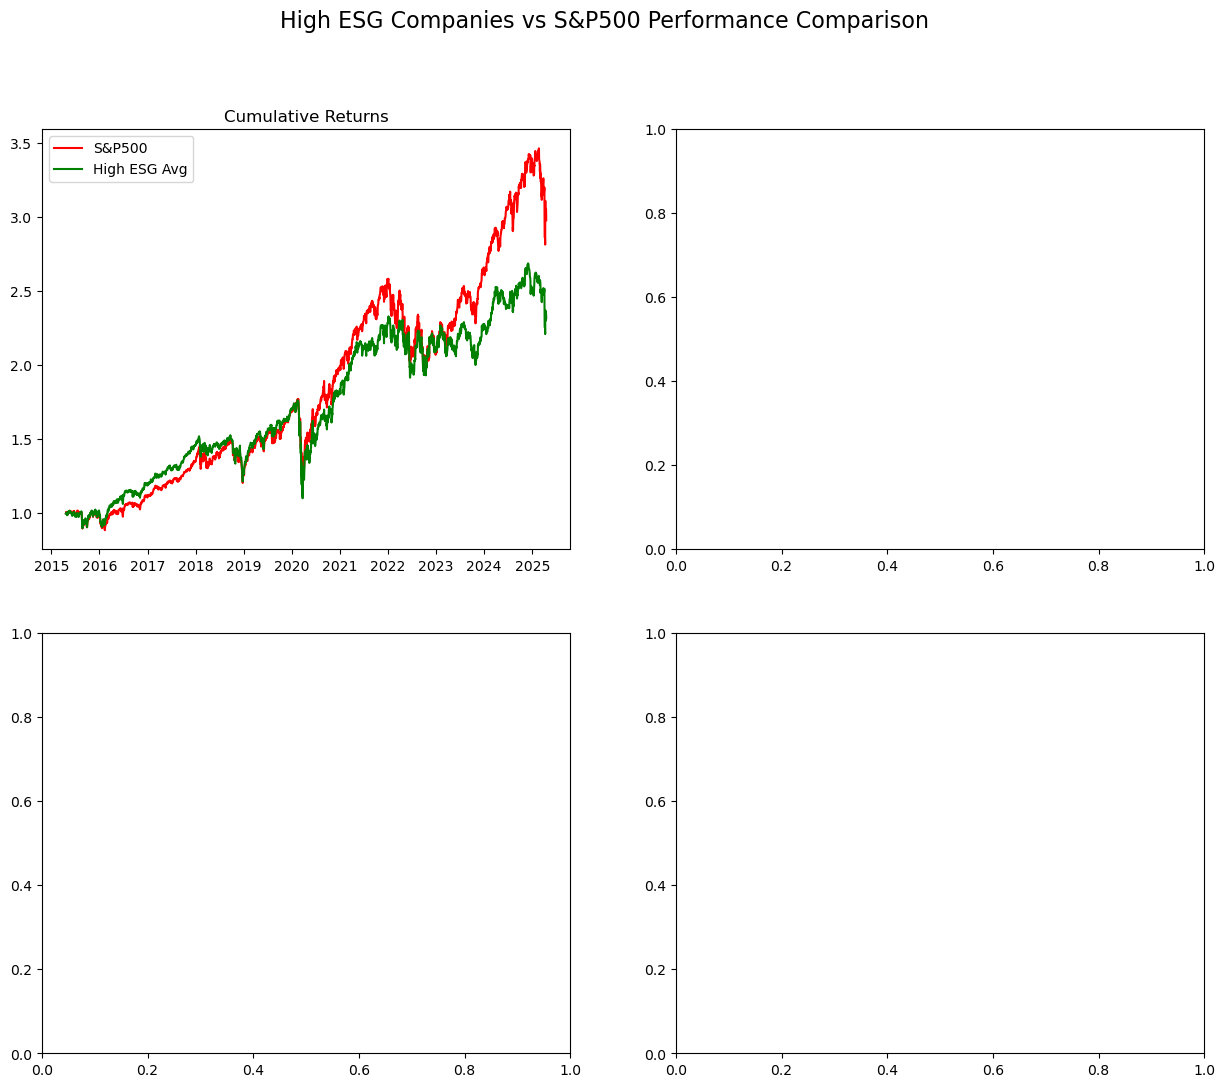

In [44]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('High ESG Companies vs S&P500 Performance Comparison', fontsize=16)

# Plot 1: Cumulative Returns
spy_cum_ret = (1 + spy.pct_change()).cumprod()
axes[0,0].plot(spy_cum_ret.index, spy_cum_ret.values, 'r-', label='S&P500')

# Average ESG returns
high_esg_cum_rets = []
for prices in high_esg_data.values():
    cum_ret = (1 + prices.pct_change()).cumprod()
    high_esg_cum_rets.append(cum_ret)

avg_high_esg_cum_ret = pd.concat(high_esg_cum_rets, axis=1).mean(axis=1)
axes[0,0].plot(avg_high_esg_cum_ret.index, avg_high_esg_cum_ret.values, 'g-', label='High ESG Avg')
axes[0,0].set_title('Cumulative Returns')
axes[0,0].legend()

# Plot 2: Annual Returns
spy_annual = spy.pct_change(252).dropna() * 100
esg_annual = pd.concat([prices.pct_change(252).dropna() * 100 for prices in high_esg_data.values()], axis=1)

axes[0,1].boxplot([spy_annual, esg_annual.mean(axis=1)], labels=['S&P500', 'High ESG'])
axes[0,1].set_title('Annual Returns Distribution')
axes[0,1].set_ylabel('Return (%)')

# Plot 3: Rolling Volatility (252-day)
spy_vol = spy.pct_change().rolling(252).std() * np.sqrt(252) * 100
esg_vol = pd.concat([prices.pct_change().rolling(252).std() * np.sqrt(252) * 100 
                     for prices in high_esg_data.values()], axis=1).mean(axis=1)

axes[1,0].plot(spy_vol.index, spy_vol.values, 'r-', label='S&P500')
axes[1,0].plot(esg_vol.index, esg_vol.values, 'g-', label='High ESG Avg')
axes[1,0].set_title('Rolling Volatility (1-year)')
axes[1,0].set_ylabel('Volatility (%)')
axes[1,0].legend()

# Plot 4: Rolling Sharpe Ratio (252-day)
rf_rate = 0.02  # Assume 2% risk-free rate
spy_sharpe = (spy.pct_change().rolling(252).mean() - rf_rate/252) / (spy.pct_change().rolling(252).std()) * np.sqrt(252)
esg_sharpe = pd.concat([(prices.pct_change().rolling(252).mean() - rf_rate/252) / 
                        (prices.pct_change().rolling(252).std()) * np.sqrt(252) 
                        for prices in high_esg_data.values()], axis=1).mean(axis=1)

axes[1,1].plot(spy_sharpe.index, spy_sharpe.values, 'r-', label='S&P500')
axes[1,1].plot(esg_sharpe.index, esg_sharpe.values, 'g-', label='High ESG Avg')
axes[1,1].set_title('Rolling Sharpe Ratio (1-year)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average Annual Return - S&P500: {spy_annual.mean():.2f}%")
print(f"Average Annual Return - High ESG: {esg_annual.mean().mean():.2f}%")
print(f"\nAverage Volatility - S&P500: {spy_vol.mean():.2f}%")
print(f"Average Volatility - High ESG: {esg_vol.mean():.2f}%")
print(f"\nAverage Sharpe Ratio - S&P500: {spy_sharpe.mean():.2f}")
print(f"Average Sharpe Ratio - High ESG: {esg_sharpe.mean():.2f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

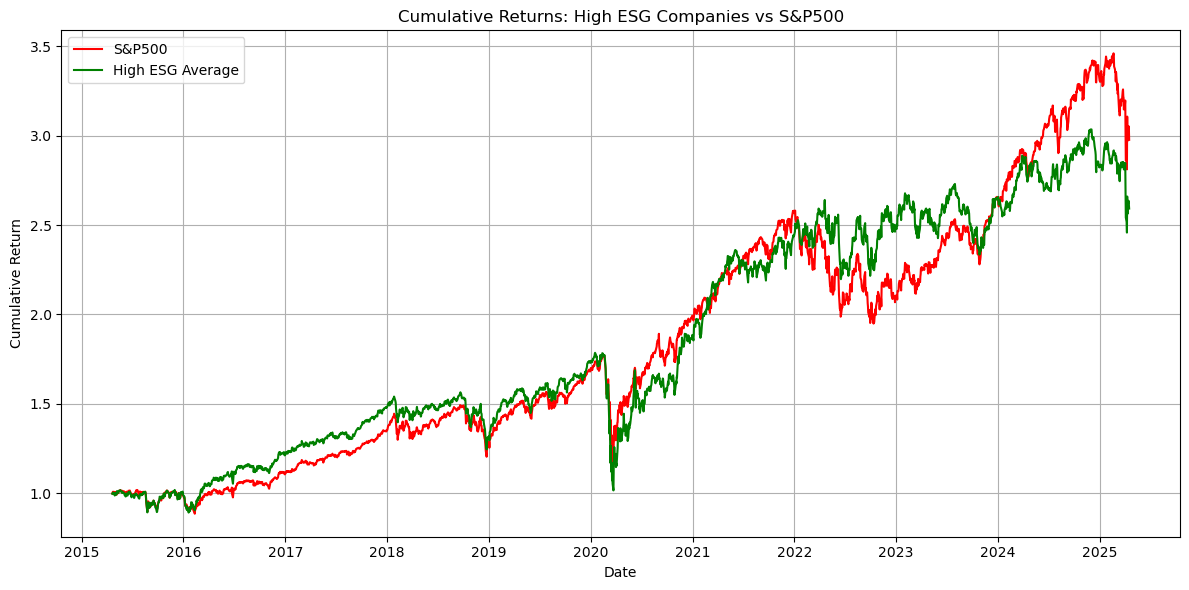


Summary Statistics:
Annual Return - S&P500: 11.55%
Annual Return - High ESG: 10.02%
Annual Volatility - S&P500: 18.22%
Annual Volatility - High ESG: 19.77%


In [45]:
# 4. Get High ESG companies data and calculate returns
all_returns = pd.DataFrame()
all_returns['SPY'] = spy.pct_change()

for ticker in high_esg_companies:
    try:
        stock = yf.download(ticker, start=start_date_10y, end=end_date)
        if not stock.empty:
            # Get close prices and calculate returns
            close_prices = stock.loc[:, ('Close', ticker)]
            all_returns[ticker] = close_prices.pct_change()
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

# 5. Calculate average ESG returns
all_returns['High_ESG_Avg'] = all_returns.drop('SPY', axis=1).mean(axis=1)

# 6. Create simple plots
plt.figure(figsize=(12, 6))

# Calculate and plot cumulative returns
cum_returns = (1 + all_returns).cumprod()
plt.plot(cum_returns.index, cum_returns['SPY'], 'r-', label='S&P500')
plt.plot(cum_returns.index, cum_returns['High_ESG_Avg'], 'g-', label='High ESG Average')

plt.title('Cumulative Returns: High ESG Companies vs S&P500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Print summary statistics
annual_return_spy = (cum_returns['SPY'].iloc[-1] ** (252/len(cum_returns)) - 1) * 100
annual_return_esg = (cum_returns['High_ESG_Avg'].iloc[-1] ** (252/len(cum_returns)) - 1) * 100
vol_spy = all_returns['SPY'].std() * np.sqrt(252) * 100
vol_esg = all_returns['High_ESG_Avg'].std() * np.sqrt(252) * 100

print("\nSummary Statistics:")
print(f"Annual Return - S&P500: {annual_return_spy:.2f}%")
print(f"Annual Return - High ESG: {annual_return_esg:.2f}%")
print(f"Annual Volatility - S&P500: {vol_spy:.2f}%")
print(f"Annual Volatility - High ESG: {vol_esg:.2f}%")

In [39]:
# Create quartiles for each ESG component
for score in ['environmentScore', 'socialScore', 'governanceScore']:
    df[f'{score}_quartile'] = pd.qcut(df[score], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Plot return distributions by ESG quartiles
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Returns by Environmental Quartile',
                                   'Returns by Social Quartile',
                                   'Returns by Governance Quartile'))

for i, score in enumerate(['environmentScore', 'socialScore', 'governanceScore']):
    fig.add_trace(
        go.Box(x=df[f'{score}_quartile'], y=df['12M_Return'],
               name=score.replace('Score', '')),
        row=1, col=i+1
    )

fig.update_layout(height=400, width=1200,
                  title_text='Return Distributions by ESG Component Quartiles')
fig.show()